# Лабораторная работа 1

Не забываем загрузить библиотеки:

In [2]:
# Библиотека для работы с матрицами
import numpy as np 

# Алгоритмы линейной алгебры
import scipy.linalg as sla

# Библиотека для работы с разреженными матрицами
import scipy.sparse as sps

# Алгоритмы линейной алгебры для разреженных матриц
import scipy.sparse.linalg as spla

# Графическая библиотека
import matplotlib.pyplot as plt

# Библиотека для измерения времени
import timeit

import scipy.io as sio

# Позволяет отрисовывать графики и изображения прямо в ноутбуке, а не в отдельном окне. Жизненно важная вещь!
%matplotlib inline

## Часть 1. Особенности LU-разложения

С точки зрения математики матричные разложения являются точными: произведение сомножителей всегда равняется исходной матрицы $A$. К сожалению, на практике этом часто мешает вычислительная погрешность. 

Для $LU$ разложения l2-норма ошибки ошибки $||\delta A|| = ||A - LU||$ удовлетворяет следующей оценке:

$$||\delta A|| \leqslant ||L|| \cdot ||U|| \cdot O(\varepsilon_{machine})$$

А нормы $L$ и $U$ могут быть совсем нехорошими.

**Задание 1.1 (1 балл)** Рассмотрим следующее LU-разложение:

$$\begin{pmatrix}
10^{-20} & 1\\
1 & 1
\end{pmatrix} = \begin{pmatrix}
1 & 0\\
10^{20} & 1
\end{pmatrix}\cdot\begin{pmatrix}
10^{-20} & 1\\
0 & 1 - 10^{20}
\end{pmatrix}$$

Перемножьте полученные матрицы $L$ и $U$. А теперь перемножьте такие же матрицы, только после всех единиц поставьте десятичные точки. Изменился ли ответ? Как вам кажется, почему?

In [3]:
a = np.array([[1, 0], [10 **20, 1]])
b = np.array([[10 ** (-20), 1], [0, 1 - 10 ** 20]])
c = np.dot(a, b)
print c

[[1e-20 1L]
 [1.0 1L]]


In [4]:
a = np.array([[1., 0], [10 **20, 1.]])
b = np.array([[10 ** (-20), 1.], [0, 1. - (10 ** 20)]])
c = np.dot(a, b)
print c

[[1e-20 1.0]
 [1.0 0.0]]


## Ответ
Ответ изменился т.е числа типа float не поддерживают длинную арифметику, и число 1. - (10 ** 20) == -1e20, 
поэтому нижний правый элемент матрицы результата - изменился на нулевой.

Отметим, что в реальных вычислениях матричные элементы почти наверняка с самого начала будут числами с плавающей точкой (а не целыми).

Теперь проверьте, что будет, если вычислить QR-разложение исходной матрицы и перемножить матрицы $Q$ и $R$.

In [5]:
A = np.array([[10 ** (-20), 1.],[1., 1.]])
a, b = sla.qr(A)
Anew = np.dot(a, b)
Anew

array([[ 0.,  1.],
       [ 1.,  1.]])

**Выход: LU-разложение с выбором главного элемента (по столбцу)**

Каждый раз ищем максимум в столбце и переставляем соответствующую строку наверх.

$$\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow
\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & b_{i+1,i} & b_{i+1,i+1} & \dots & b_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & \color{blue}{b_{ii}} & \color{blue}{b_{i,i+1}} & \dots & \color{blue}{b_{in}} \\
 & & \vdots & \vdots & & \vdots\\
\end{pmatrix}\longrightarrow$$
$$\longrightarrow\begin{pmatrix}
b_{11} & \dots & b_{1i} & b_{1,i+1} & \dots & b_{1n}\\
 & \ddots & \vdots & \vdots & & \vdots\\
 & & \color{green}{b_{ji}} & \color{green}{b_{j,i+1}} & \dots & \color{green}{b_{jn}} \\
 & & 0 & b'_{i+1,i+1} & \dots & b'_{i+1,n}\\
 & & \vdots & \vdots &  & \vdots \\
 & & 0 & b'_{i,i+1} & \dots & b'_{in} \\
 & & \vdots & \vdots & & \vdots
\end{pmatrix}$$

Надо сказать, что примерно так вы все и решали системы на первом курсе университета! Именно наибольший, а не первый ненулевой элемент столбца берётся потому, что чем больше число - тем меньшие погрешности потенциально вносит деление на него.

Что при этом происходит? Перестановка строк матрицы равносильна умножению её слева на матрицу соответствующей перестановки. Таким образом, мы получаем равенство

$$L_nP_nL_{n-1}P_{n-1}\ldots L_2P_2L_1P_1 A = U\qquad\qquad(1)$$

где $L_1,\ldots,L_n$ - некоторые нижнетреугольные матрицы.

**Вопрос:** Ну, и где здесь матрица $L$?!

**Ответ:** Введём новые матрицы

\begin{align*}
L'_n &= L_n\\
L'_{n-1} &= P_nL_nP_{n-1}\\
L'_{n-2} &= P_nP_{n-1}L_{n-1}P_n^{-1}P_{n-1}^{-1}\\
&\ldots\\
L'_1 &= P_nP_{n-1}\ldots P_2L_1P_2^{-1}\ldots P_{n-1}^{-1}P_n^{-1}
\end{align*}

**Упражнение.** Матрицы $L'_i$ тоже нижнетреугольные!

Тогда левая часть (1) перепишется в виде

$$\underbrace{L'_nL'_{n-1}\ldots L'_1}_{:=L^{-1}}\underbrace{P_nP_{n-1}\ldots P_1}_{:=P^{-1}}\cdot A$$

**Итог:** разложение вида
$$A = PLU$$
где $P$ - матрица перестановки.

Функция `scipy.linalg.lu` в Питоне находит именно такое разложение!

Все элементы $L$ не превосходят $1$, так что $||L||]\leqslant 1$. При этом
$$||\Delta A|| \leqslant ||A||\cdot O(\rho \varepsilon_{machine}),$$
где
$$\rho = \frac{\max_{i,j}|u_{ij}|}{\max_{i,j}|a_{ij}|}$$

Но что, если это отношение велико?

# **Задание 1.2 (1 балл)** Сгенерируйте матрицу $500\times500$, имеющую вид

$$\begin{pmatrix}
1 & 0 & 0 & \cdots & 0 & 0 & 1\\
-1 & 1 & 0 &  &  & 0 & 1\\
-1 & -1 & 1 & 0  &  & 0 & 1\\
\vdots & & \ddots & \ddots  & \ddots & \vdots & \vdots \\
-1 & -1 & -1 & \ddots & 1 & 0 & 1\\
-1 & -1 & -1 &  & -1 & 1 & 1\\
-1 & -1 & -1 & \cdots & -1 & -1 & 1
\end{pmatrix}$$

Например, сгенерировать сначала нулевую матрицу нужного размера, а потом заполнить её клетки правильными числами.

Найдите её PLU-разложение и QR-разложение. Убедитесь, что $P = E$. Вычислите $||A - LU||_2$ и $||A - QR||_2$. Чему равен фактор роста матрицы $A$?

In [6]:
def pivot_matrix(m):
    n = len(m)    
    ind = [[float(i == j) for i in xrange(n)] for j in xrange(n)]
    ind = np.asarray(ind, dtype = np.float)
    return ind
    for j in xrange(n):
        row_ind = np.argmax(np.abs(m[j:, j])) + j     
        if row_ind != j:
            ind[j], ind[row_ind] = ind[row_ind], ind[j]
    return ind

def lu_decomposition(a):
    n = a.shape[0]
    L = np.zeros(a.shape)
    U = np.zeros(a.shape)

    P = pivot_matrix(a)
    PA = np.dot(P, a)
    #print PA
    for j in xrange(n):
        L[j][j] = 1.0
        for i in xrange(j+1):
            s1 = np.sum((U[:, j] * L[i, :])[:i])
            #print s1
            U[i][j] = PA[i][j] - s1

        for i in xrange(j, n):
            s2 = np.sum((U[:,j] * L[i, :])[:j])
            #print s2
            L[i][j] = (PA[i][j] - s2) / U[j][j]
        #print L, U


    return (P, L, U)

In [7]:
def getQRDecomposition(a):
    u = []
    u.append(a[0, :].copy())
    #print a
    for i in range(1, len(a)):
        bi = a[i , :].copy()
        for j in range(len(u)):
            bi -= (np.sum(a[i, :] * u[j])) / (np.sum(u[j] ** 2)) * u[j]
        #bi /= np.sqrt(np.sum(bi * bi))
        u.append(bi)
    #print a
    for i in range(len(u)):
        u[i] /= np.sqrt(np.sum(u[i] ** 2))
    Q = np.asarray(u, dtype = np.float)
    #print a
    R = np.dot(Q.T, a)
    return Q, R

In [17]:
a = np.zeros((500, 500))
for i in range(500):
    for j in range(500):
        if i == j:
            a[i][j] = 1
        elif j == 499:
            a[i][j] = 1
        elif i > j:
            a[i][j] = -1
            
P, L, U = sla.lu(a)
#L = np.dot(P, L)
for i in range(len(P)):
    for j in range(len(P)):
        if i == j:
            assert P[i][j] == 1.
        else:
            assert P[i][j] == 0
#print a
Q, R = sla.qr(a)
deltaLU = sla.norm((a - np.dot(L, U)))
deltaQR = sla.norm((a - np.dot(Q, R)))
factorLU = np.abs(U).max()/np.abs(a).max()
print 'norm LU decomposition: ', deltaLU
print 'norm QR, decomposition: ', deltaQR
print 'growth factor LU:', factorLU

[[ 1.  0.  0. ...,  0.  0.  1.]
 [-1.  1.  0. ...,  0.  0.  1.]
 [-1. -1.  1. ...,  0.  0.  1.]
 ..., 
 [-1. -1. -1. ...,  1.  0.  1.]
 [-1. -1. -1. ..., -1.  1.  1.]
 [-1. -1. -1. ..., -1. -1.  1.]]
norm LU decomposition:  2.53295195207e+76
norm QR, decomposition:  1.55336004413e-12
growth factor LU: 1.63669530395e+150


К счастью, на практике так редко бывает (чёрт его знает почему). Тем не менее, QR-разложение всё-таки лучше. Теоретическая оценка для ошибки QR-разложения имеет вид

$$||A - QR||_2 \leqslant ||A||_2\cdot O(\varepsilon_{machine})$$

**Задание 1.3 (1 балл)** Рассмотрим *матрицу Паскаля* $S_n = \left(C_{i + j}^i\right)$ ($i,j = 0,\ldots,n-1$).

Каково её LU-разложение? Выведите формулы для матриц L и U и приведите краткое обоснование прямо в ноутбуке. Не пользуйтесь функцией `scipy.linalg.lu`, чтобы его "угадать": матрица P будет отлична от единичной, и вы получите не то, что хотели.

Каков её определитель?

U[i][j] = A[i][j - i] если i > j U[i][j] = 0  
L[i][j] = A[i - j][j] если i < j L[i][j] = 0

Таким образом:

$L_{i, j} = \left(C_{i}^{i - j}\right)$
$U_{i, j} = \left(C_j^{i}\right)$.

$A_{i, j} = \sum_{k = 0}^{n} L_{i, k} * U_{k, j}$

$A_{i, j} = \sum_{k = 0}^{min_{i, j}} \left(C_i^{i - k}\right) * \left(C_j^{k}\right) $  (1)

Заметим, что

${(1 + x)^{i + j}} = {(1 + x) ^ i} * {(1 + x) ^ j}$

Далее в этом равенстве приравняем коэффициент слева при ${x^i}$ и при соответствующей степенью x, в правой части, получим (1)

Напишите функцию `my_pascal(n)`, генерирующую матрицу Паскаля размера $n\times n$.

Найдите норму разности $||A - PLU||_2$. Не такая уж и большая, правда?

In [31]:
###
# Your function here
def my_pascal(size):
    a = np.zeros((size, size))
    a[0, :] = np.ones(size)
    a[:, 0] = np.ones(size)
    for i in xrange(1, size):
        for j in xrange(1, size):
            a[i][j] = a[i - 1][j] + a[i][j - 1]
    return a
    
###

A = my_pascal(30)
p, l, u = sla.lu(A)
print sla.norm((A - np.dot(np.dot(p, l), u)))

2.31466102561


Теперь попросим компьютер вычислить определитель матрицы Паскаля $30\times30$ и решить простенькую систему уравнений:

In [27]:
print(sla.det(A))

# Try to solve a linear system
x = np.ones(30)
b = A.dot(x)
x1 = sla.solve(A, b)
print(sla.norm(x1 - x))

-3.01736842766e+49
492533426.521


Так себе ошибка. Теперь попробуем сделать это с помощью QR-разложения. Станет ли лучше?

In [28]:
Q, R = sla.qr(A)
x2 = sla.solve_triangular(R, Q.T.dot(b))
print sla.norm(x2 - x)

965320173.567


Объясните полученные неприятные результаты.

----
*Ваш ответ*

## Часть 2. Решение СЛАУ с положительно определённой матрицей

**Задание 2.1. Какие же методы использовать? (3 балла)**

Реализуйте несколько алгоритмов решения СЛАУ $Ax = b$, где $A = A^T$, $A \geqslant 0$ с матричной правой частью $b$.

1. **Наивный способ**: $x = A^{-1}b$;

2. **Стандартный способ**: с помощью процедуры `solve` модуля `scipy.linalg`;

3. **Разложение Холецкого**: с помощью разложения Холецкого для матрицы $A$ и последующего решения двух СЛАУ с треугольными матрицами;

4. **Разложение Холецкого с процедурами scipy**: с помощью разложения Холецкого для матрицы $A$ и специальных процедур из пакета `scipy.linalg` (`cho_factor`, `cho_solve`).

Для решения СЛАУ с треугольной матрицей можно воспользоваться функцией `solve_triangular` из пакета `scipy.linalg`.

In [34]:
def naive_solve(A, b):
    return np.dot(sla.inv(A), b)

def standart_solve(A, b):
    return sla.solve(A, b)

def cholesky_simple(A, b):
    lower = sla.cho_factor(A, lower = True)[0]
    y = sla.solve_triangular(lower, b, lower = True)
    x = sla.solve_triangular(lower.T, y, lower = False)
    return x
    
def cholesky_scipy(A, b):
    lower = sla.cho_factor(A)
    #lower = np.asarray(lower)
    return sla.cho_solve(lower, b)


Проведите тестирование реализованных алгоритмов на небольшой СЛАУ на предмет совпадения ответов

In [35]:
def gen_matrix(sz):
    a = np.abs(np.random.randn(sz, sz)) * 0.001
    a += np.eye(N = sz) * 0.0001
    return np.dot(a, a.T)
sz = 20
A = gen_matrix(sz)
b = np.abs(np.random.randn(sz))

In [36]:
x1 = naive_solve(A, b)
x2 = standart_solve(A, b)
x3 = cholesky_simple(A, b)
x4 = cholesky_scipy(A, b)
print sla.norm(x1 - x2)
print sla.norm(x1 - x3)
print sla.norm(x1 - x4)

2.79501041654e-08
1.92825888846e-06
4.06170651046e-06


Проведите эксперименты и выясните, как меняется время работы этих методов

- с ростом размера матрицы $A$ при фиксированном числе правых частей. Рассмотрите системы с 10, 100, 1000 правых частей;

- с ростом числа правых частей при фиксированном размере матрицы $A$ (например, $100\times100$).

Обязательно нарисуйте графики (время работы от размера). Какой метод оказывается более быстрым?

Для тестирования вам пригодятся случайные матрицы, сгенерированные с помощью функции `numpy.random.randn`. Но не забудьте, что в задаче речь идёт о *симметрических положительно определённых матрицах*. Так что подумайте, как из случайных матриц сделать симметрические положительно определённые.

Матрицы левых частей должны быть не менее $100\times100$: при меньших размерностях заметную роль могут играть факторы, не имеющие отношения к алгебре. Мы рекомендуем рассматривать системы с матрицами размера от 100 до 1000 и с числом правых частей от 10 до 10000. Приготовьтесь к тому, что эксперименты могут занять какое-то время.

## график зависимости времени от роста размера матрицы А при фиксированном числе правых частей

In [7]:
from timeit import timeit

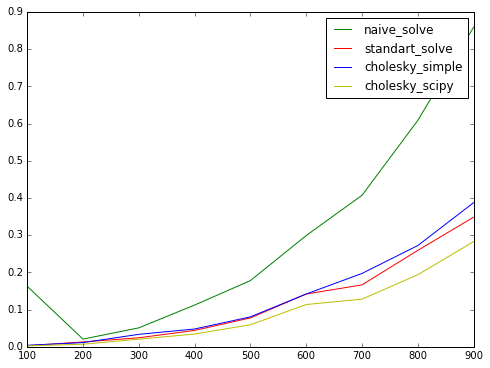

In [192]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(10):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(10)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 10 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

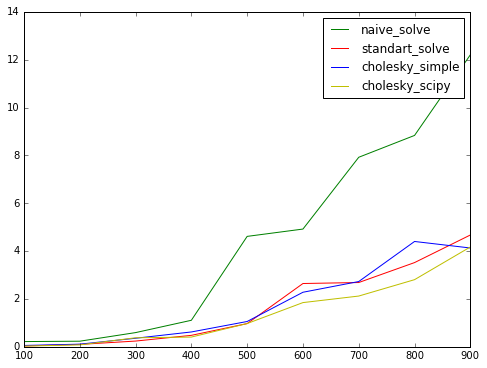

In [193]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(100):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(100)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 100 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

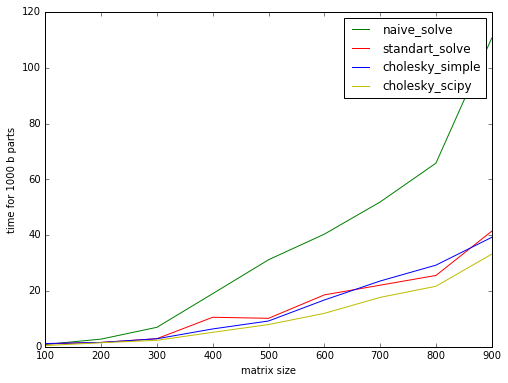

In [194]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(100, 1000, 100)
for sz in range(100, 1000, 100):
    A = gen_matrix(sz)
    b = []
    for j in range(1000):
        b.append(np.abs(np.random.randn(sz)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(1000)]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('matrix size')
plt.ylabel('time for 1000 b parts')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

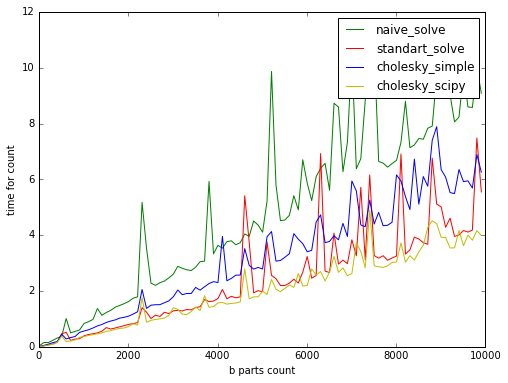

In [196]:
time_naive_solve = []
time_standart_solve = []
time_cholesky_simple = []
time_cholesky_scipy = []
x = np.arange(10, 10000, 100)
A = gen_matrix(100)
for sz in range(10, 10000, 100):
    b = []
    for j in range(sz):
        b.append(np.abs(np.random.randn(100)))
    
    time_naive_solve.append(timeit('[naive_solve(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import naive_solve, A, b'))
    time_standart_solve.append(timeit('[standart_solve(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import standart_solve, A, b'))
    time_cholesky_simple.append(timeit('[cholesky_simple(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import cholesky_simple, A, b'))
    time_cholesky_scipy.append(timeit('[cholesky_scipy(A, b[j]) for j in range(len(b))]', number = 1, setup = 'from __main__ import cholesky_scipy, A, b'))

plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_naive_solve, c ='g')
line2, = plt.plot(x, time_standart_solve, c = 'r')
line3, = plt.plot(x, time_cholesky_simple, c = 'b')
line4, = plt.plot(x, time_cholesky_scipy, c = 'y')
plt.xlabel('b parts count')
plt.ylabel('time for count')
plt.legend([line1, line2, line3, line4], ['naive_solve', 'standart_solve', 'cholesky_simple', 'cholesky_scipy'])
plt.show()

**Задание 2.2. Пример: вычисление логарифма плотности многомерного нормального распределения (3 балла)**

Случайная величина $\vec{x}\in\mathbb{R}^D$ имеет многомерное нормальное распределение, если её плотность может быть представлена как
$$
p(\vec{x}) = \mathcal{N}(\vec{x}|\vec{\mu},\Sigma) = \frac{1}{\sqrt{2\pi}^D\sqrt{\det\Sigma}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
Здесь $\vec{\mu}\in\mathbb{R}^D -$ вектор мат. ожидания $\vec{x}$, а $\Sigma\in\mathbb{R}^{D{\times}D} -$ матрица ковариации.

С помощью матричных разложений реализуйте алгоритм вычисления логарифма нормальной плотности для набора векторов $X = \{\vec{x}_1,\dots,\vec{x}_N\}$ для заданных $\vec{\mu}$ и $\Sigma$.

In [37]:
#Заготовка:
def my_multivariate_normal_logpdf(X, m, S):
    '''
    Ввод*
    -----
    X: набор точек, numpy array размера N x D;
    m: вектор средних значений, numpy array длины D;
    S: ковариационная матрицы, numpy array размера D x D.
    
    Вывод
    ------
    res: результат вычислений, numpy array длины N.
    '''
    d = S.shape[0]
    lowerS = sla.cho_factor(S, lower = True)[0]
    for i in range(d):
        for j in range(i + 1, d):
            lowerS[i][j] = 0.
    det = 1
    for i in range(d):
        det *= lowerS[i][i]
    det *= det
    lowerInv = sla.inv(lowerS)
    normalizeX = X - m

    answer = []
    const_add = d * np.log(2 * np.pi) + np.log(det)
    Sinv = np.dot(lowerInv.T, lowerInv)
    mat = np.dot(normalizeX, Sinv)
    answer = np.sum(mat * normalizeX, axis = 1)
    #answer = map(lambda x, y: np.dot(x, y.T), mat, normalizeX)
    #print answer
    #for i in range(normalizeX.shape[0]):
    #    answer.append(np.dot(np.dot(normalizeX[i], Sinv), normalizeX[i].T))

    answer = np.asarray(answer, dtype = np.float)
    return -(answer + const_add)* 0.5

Сгенерируйте выборку из нормального распределения со случайными параметрами для небольшого $D$ с помощью функции `scipy.stats.multivariate_normal.rvs` и сравните на этой выборке результат работы вашего алгоритма с результатом стандартной функции `scipy.stats.multivariate_normal.logpdf`

In [38]:
import scipy.stats

In [42]:
D = 30
covMatrix = gen_matrix(D)
mean = np.random.randn(D)
X = scipy.stats.multivariate_normal.rvs(mean, covMatrix, 100)
logPScipy = scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)
logPMyImpl = my_multivariate_normal_logpdf(X, mean, covMatrix)
print sla.norm(logPScipy - logPMyImpl)

3.32181578726e-12


Замерьте время работы вашего алгоритма и функции `scipy.stats.multivariate_normal.logpdf` для различных значений $D$. Постарайтесь добиться, чтобы ваш алгоритм выигрывал по скорости у стандартной функции.

In [43]:
from timeit import timeit

In [44]:
x = np.arange(100, 500, 100)
time_scipy = []
time_my_impl = []
for d in range(100, 500, 100):
    D = d
    covMatrix = gen_matrix(D)
    mean = np.random.randn(D)
    #print sla.det(covMatrix)
    X = scipy.stats.multivariate_normal.rvs(mean, covMatrix, 100)
    time_scipy.append(timeit('scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)', number = 100, setup = 'from __main__ import naive_solve, X, mean, covMatrix, scipy') / 100.)
    time_my_impl.append(timeit('my_multivariate_normal_logpdf(X, mean, covMatrix)', number = 100, setup = 'from __main__ import X, mean, covMatrix, scipy, my_multivariate_normal_logpdf') / 100.)

    #logPScipy = scipy.stats.multivariate_normal.logpdf(X, mean, covMatrix)
    #logPMyImpl = my_multivariate_normal_logpdf(X, mean, covMatrix)
    #print sla.norm(logPScipy - logPMyImpl)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


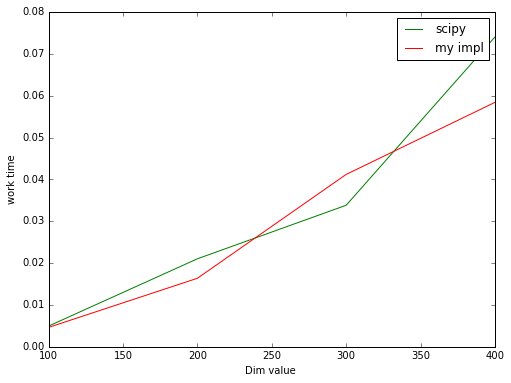

In [45]:
#print len(time_scipy)
#print len(time_my_impl)
#print len(x)
plt.figure(figsize = (8, 6), dpi = 80)
line1, = plt.plot(x, time_scipy, c = 'g')
line2, = plt.plot(x, time_my_impl, c = 'r')
plt.xlabel('Dim value ')
plt.ylabel('work time')
plt.legend([line1, line2], ['scipy', 'my impl'])
plt.show()

В задаче будут оцениваться:
- удалось ли вам обогнать библиотечную функцию;
- использованы ли вы матричные разложения (или просто обратили матрицу:))
- наличие дополнительных оптимизаций

## Часть 3. Разреженные матрицы

Матрица называется разреженной, если в ней мало ненулевых элементов.

Например, если в матрице $n\times n$ порядка $O(n)$ ненулевых элементов, она является разреженной.

Зачастую размерность разреженных матриц, возникающих в реальных задачах, так велика, что хранить её в памяти вместе с нулями - непозволительная роскошь. Есть несколько экономичных методов хранения:

- `Dictionary of Keys` (`DOK`) - словарь `(i,j):element`. 

    $\color{green}{\oplus}$ быстрое добавление элементов с произвольными индексами,
  
    $\color{red}{\ominus}$ любые другие операции будут производиться медленно.


- `List of Lists` (`LIL`) - матрица хранится построчно: в виде двух массивов `[l_1,...,l_s]` и `[v_1,...v_s]`, где `l_i` - список номеров столбцов, в которых в i-й строке находится ненулевой элемент, а `v_i` - список соответствующих значений. В целом, подходит для создания в высокой степени разреженной матрицы. Когда все элементы добавлены, лучше перевести в формат `CSR` или `CSC`.

    $\color{green}{\oplus}$ добавление за линейное время, 
    
    $\color{green}{\oplus}$ быстрый доступ к строкам матрицы, 
    
    $\color{red}{\ominus}$ может требовать слишком много памяти (для создания матриц повышенной плотности используйте `COO`).

    
- `Coordinate List` (`COO`) - хранятся тройки `(row, column, value)`  или три массива \texttt{rows,\ columns,\ values}. При этом тройка с одинаковым началом `(row, column)` может быть не одна; при преобразовании к другому типу значения `value` суммируются.

    $\color{green}{\oplus}$ быстрое добавление новых элементов,
    
    $\color{red}{\ominus}$ для всего остального лучше перевести в другой формат.
    
    
- `Compressed Sparse Row/Column storage` (`CSR/CSC`) - разберём на примере `CSR`. Хранятся три массива: `values`, `indptr` и `indices`. В массиве `values` хранятся все ненулевые элементы матрицы, упорядоченные лексикографически по паре (строка, столбец); `indptr[i]` - индекс начала `i`-й строки, `indices[indptr[i]:indptr[i+1]-1]` - номера столбцов соответствующих элементов.

    $\color{green}{\oplus}$ быстрое выполнение арифметических операций,
    
    $\color{green}{\oplus}$ быстрый доступ к строкам для `CSR` и к столбцам для `CSC`,
    
    $\color{red}{\ominus}$ очень медленный доступ к столбцам для `CSR` и к строкам для `CSC`,
    
    $\color{red}{\ominus}$ медленное добавление/удаление элементов.
  

Главный вывод - не надо один и тот же формат использовать для разных целей!

Вот здесь http://docs.scipy.org/doc/scipy/reference/sparse.html можно посмотреть, как эти возможности реализованы в библиотеке `scipy`.

Вот здесь https://www.cise.ufl.edu/research/sparse/matrices/index.html выложено много разреженных матриц из разнообразных приложений. Что особенно приятно, сайт предоставляет удобный клиент для скачивания, в котором доступен предпросмотр и данные о том, являются ли матрицы симметричными или положительно определёнными.

**Задание 3.0** Загрузите файл `sparse_matrix1.mtx`

In [585]:
import scipy.io as sio

In [588]:
A = sio.mmread(r'sparse_matrix1.mtx') # Please type right folder name! 

С помощью следующей функции можно посмотреть, как расположены ненулевые элементы матрицы:

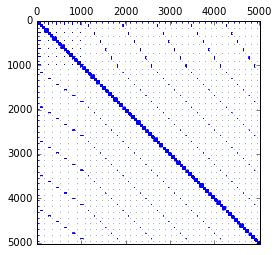

In [589]:
plt.spy(A, marker='.', markersize=0.4)

В каком из пяти форматов хранится матрица? Для ответа на этот вопрос воспользуйтесь функцию `type`.

Сколько в ней ненулевых элементов?

In [591]:
print type(A)
print A.nnz

<class 'scipy.sparse.coo.coo_matrix'>
94026


Посмотрим, сколько времени занимает преобразование между разными форматами.

In [595]:
import pandas as pd
import timeit

A_dok = A.todok()
A_lil = A.tolil()
A_csc = A.tocsc()
A_csr = A.tocsr()

conversion_times = pd.DataFrame(
    index=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    columns=['COO', 'DOK', 'LIL', 'CSR', 'CSC'],
    data={
        'COO': [
            np.nan,
            timeit.timeit('A.todok()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tolil()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsr()', 'from __main__ import A', number=100) / 100,
            timeit.timeit('A.tocsc()', 'from __main__ import A', number=100) / 100,
               ],
        'DOK': [
            timeit.timeit('A_dok.tocoo()', 'from __main__ import A_dok', number=100) / 100,
            np.nan,
            timeit.timeit('A_dok.tolil()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsr()', 'from __main__ import A_dok', number=100) / 100,
            timeit.timeit('A_dok.tocsc()', 'from __main__ import A_dok', number=100) / 100,
               ],
        'LIL': [
            timeit.timeit('A_lil.tocoo()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.todok()', 'from __main__ import A_lil', number=100) / 100,
            np.nan,
            timeit.timeit('A_lil.tocsr()', 'from __main__ import A_lil', number=100) / 100,
            timeit.timeit('A_lil.tocsc()', 'from __main__ import A_lil', number=100) / 100,
               ],
        'CSR': [
            timeit.timeit('A_csr.tocoo()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.todok()', 'from __main__ import A_csr', number=100) / 100,
            timeit.timeit('A_csr.tolil()', 'from __main__ import A_csr', number=100) / 100,
            np.nan,
            timeit.timeit('A_csr.tocsc()', 'from __main__ import A_csr', number=100) / 100,
               ],
        'CSC': [
            timeit.timeit('A_csc.tocoo()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.todok()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tolil()', 'from __main__ import A_csc', number=100) / 100,
            timeit.timeit('A_csc.tocsr()', 'from __main__ import A_csc', number=100) / 100,
            np.nan,
               ],
    }
    )

conversion_times.T

,COO,DOK,LIL,CSR,CSC
COO,NaN,0.053364,0.015230,0.000683,0.000743
DOK,0.091114,NaN,0.118613,0.094808,0.094615
LIL,0.013389,0.088248,NaN,0.014040,0.014946
CSR,0.000921,0.067411,0.014173,NaN,0.000500
CSC,0.000663,0.068763,0.015476,0.000500,NaN


Как вы можете убедиться, быстрее всего преобразования происходят между форматами `COO`, `CSR` и `CSC`, а хуже всего дела обстоят с форматом `DOK`: все преобразования из него занимают чудовищно много времени.

**Задание 3.1 (0,5 балла)** Почему преобразование из формата `LIL` в формат `CSR` занимает такую пропасть времени?

----
Для преобразования из LIL в CSR нужно сначала пробежаться по всем элементам LIL, в порядке возрастания номера строки далее в порядке возрастания номера столбца, и записать в массив value, паралельно записывая номера столбцов в массив indicies и запоминая указатели в массив indptr каждый раз когда меняется номер строки, итого О(n) времени

**Задание 3.2 (1 балл)** Торговая сеть предоставила вам данные о покупках своих клиентов, представляющие собою список из нескольких сотен тысяч чеков (списков покупок). Для того, чтобы определить, какие товары чаще покупают вместе, вы решили построить матрицу, строки и столбцы которой соответствуют различным товарам (предположим, что число различных товаров тоже измеряется сотнями тысяч), а в клетке с "номером" $(g_1, g_2)$ стоит число

$\log_2{\frac{N\cdot c(g_1 \& g_2)}{c(g_1)c(g_2)}},$

где $c(g_i)$ --- количество чеков, содержащих товар $g_i$, $c(g_1 \& g_2)$ --- количество чеков, содержащих оба товара, $N$ --- общее число чеков. В каком формате вы будете создавать эту (очевидно разреженную) матрицу? Почему?

Для этой задачи я буду использовать COO матрицу, ее плюсы состоят в том, что она позволяет быстро добавлять элементы, для статистики по встречаемости элемента я буду использовать диагональные элементы матрицы, для попарной статистики я буду использовать ячейки i, j, т.е добавлять что пара элементов встретилась, если ее до этого не было в матрице или инкрементировать кол-во на единицу
Дальше переведу матрицу в CSR формат, чтобы непосредственно посчитать величину, т.е отношение и логарифм от него.

Напишите максимально эффективный код, создающий эту матрицу:

In [604]:
def CreateMatrix(receipts):
    # Your code here
    maxItemNum = np.max(receipts)
    A = coo_matrix(shape = (maxItemNum, maxItemNum))
    receiptsCount = len(receipts)
    for receipt in receipts:
        for num1, item1 in enumerate(receipt):
            A[num1][num1] += 1
            for num2, item2 in enumerate(receipt):
                A[num1][num2] += 1
    A = A.tocsr()
    rows,cols = A.nonzero()
    for row,col in zip(rows,cols):
        A[row][col] = np.log(receiptsCount * A[row][col] / A[row][row] / A[col][col]
    return 

**Задание 3.3 (1 балл)** В каком из форматов `LIL` и `COO` умножение на вектор происходит быстрее? Почему? Проведите эксперименты. Можете воспользоваться функцией `scipy.sparse.random` для создания случайных разреженных матриц.

Насколько быстрее с аналогичной задачей будут справляться форматы `CSC` и `CSR`?

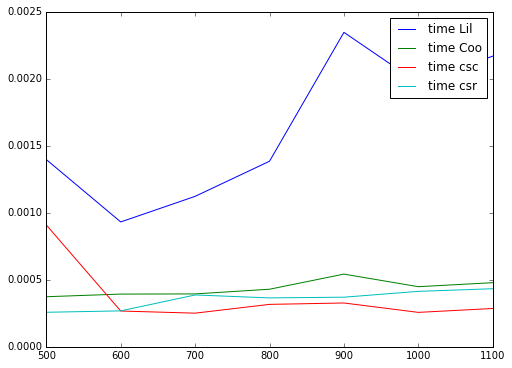

In [623]:
time_coo = []
time_lil = []
time_csc = []
time_csr = []
x = np.arange(500, 1200, 100)
for sz in range(500, 1200, 100):
    A = scipy.sparse.random(sz, sz)
    vec = scipy.sparse.random(sz, 1)
    A = A.tolil()
    time_lil.append(timeit('scipy.dot(A, vec)', number = 100, setup = 'from __main__ import naive_solve, A, vec, scipy') / 100.)
    A = A.tocoo()
    time_coo.append(timeit('scipy.dot(A, vec)', number = 100, setup = 'from __main__ import naive_solve, A, vec, scipy') / 100.)
    A = A.tocsc()
    time_csc.append(timeit('scipy.dot(A, vec)', number = 100, setup = 'from __main__ import naive_solve, A, vec, scipy') / 100.)
    A = A.tocsr()
    time_csr.append(timeit('scipy.dot(A, vec)', number = 100, setup = 'from __main__ import naive_solve, A, vec, scipy') / 100.)

plt.figure(figsize=(8, 6), dpi = 80)
line1, = plt.plot(x, time_lil)
line2, = plt.plot(x, time_coo)
line3, = plt.plot(x, time_csc)
line4, = plt.plot(x, time_csr)
plt.legend([line1, line2, line3, line4], ['time Lil', 'time Coo', 'time csc', 'time csr'])

----
*Ваш ответ:*

## Часть 4. Итерационные методы

В этом задании вам предлагается поработать с итеративными методами решения систем уравнений.

Соответствующие функции реализованы в пакете `scipy.sparse.linalg` (http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.linalg.html). Пожалуйста, читайте документацию перед их применением!

В этом задании вам предстоит поближе познакомиться с двумя итеративными методами:

1. **(L)GMRES** (мы настоятельно рекомендуем использовать оптимизированную функцию `scipy.sparse.linalg.lgmres`, даже если вам нужен обыкновенный **GMRES**)

2. **CG** (вызывается функцией `scipy.sparse.linalg.cg`)

*Замечания*:
1. Функции `scipy.sparse.linalg.lgmres` и `scipy.sparse.linalg.cs` устроены так, что могут решать уравнения только с векторной правой частью.
2. Внимательно ознакомьтесь с параметрами (у функции `scipy.sparse.linalg.lgmres` их очень много) и обратите внимание на формат вывода функций.
3. Вы можете захотеть выводить/сохранять что-нибудь после каждой итерации. Для этого существует параметр `callback`: это функция с сигнатурой `callback(xk)`, вызываемая на каждой итерации. Её аргумент `xk` - это текущее приближение $x_k$. Вот пример вызова функции `lgmres`, печатающей норму текущего приближения:

In [10]:
import sys
A = gen_matrix(100)
b = np.random.rand(100)
x = spla.gmres(A, b, callback=lambda xk: sys.stdout.write(str(sla.norm(xk)) + '\n'))

0.551534918227
0.379069432682
0.307516996981
0.263975102551
0.234741517064
0.205116009887
0.19049169594
0.174016361035
0.153719222829
0.1366815023
0.125165685072
0.112722374431
0.104129096754
0.0975291651108
0.0899780369093
0.0851942344876
0.0807746057363
0.0770602554356
0.0723825471479
0.0675766736155
0.0650443313305
0.0628629993718
0.0610876950236
0.0590369832754
0.0582049659754
0.0564512556316
0.0535833142278
0.051093763374
0.0486204088309
0.0457275828853
0.0432808338817
0.0409852503064
0.0383714633263
0.0365300816595
0.0350084150703
0.0333936414145
0.031823807807
0.0300431440829
0.0286129703421
0.0272019872974
0.0265676016118
0.0261445197489
0.0257787303181
0.0254505292817
0.0253194389329
0.0251454438163
0.0248692272437
0.0245722288825
0.0242729770505
0.0239894799932
0.0237264061898
0.0234099675842
0.0231085428501
0.0227709871756
0.0224094469226
0.0220241471641
0.0215775275442
0.0211956778923
0.0208546608213
0.0204879958686
0.020243789773
0.0200195255808
0.0197993156589
0.019531456

Если вы захотите что-нибудь сохранять по ходу дела, логичнее использовать для этого класс. Ниже приводим пример класса, считающего число итераций и выводящего (если указан флаг `disp`) номер каждой итерации на печать, а также запоминающего все промежуточные приближения (не делайте так для больших систем! вам может не хватить памяти):

In [12]:
class iterative_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
        self.all_x = [] # Please discard this if you solve large systems!!!
        
    def __call__(self, xk=None):
        self.niter += 1
        self.all_x.append(xk) # Please discard this if you solve large systems!!!
        if self._disp:
            print('iter %3i' % (self.niter))
            
my_counter = iterative_counter() # We need to create an instance of the class

x = spla.gmres(A, b, callback=my_counter)

print(my_counter.niter) # Will print total number of iterations

iter   1
iter   2
iter   3
iter   4
iter   5
iter   6
iter   7
iter   8
iter   9
iter  10
iter  11
iter  12
iter  13
iter  14
iter  15
iter  16
iter  17
iter  18
iter  19
iter  20
iter  21
iter  22
iter  23
iter  24
iter  25
iter  26
iter  27
iter  28
iter  29
iter  30
iter  31
iter  32
iter  33
iter  34
iter  35
iter  36
iter  37
iter  38
iter  39
iter  40
iter  41
iter  42
iter  43
iter  44
iter  45
iter  46
iter  47
iter  48
iter  49
iter  50
iter  51
iter  52
iter  53
iter  54
iter  55
iter  56
iter  57
iter  58
iter  59
iter  60
iter  61
iter  62
iter  63
iter  64
iter  65
iter  66
iter  67
iter  68
iter  69
iter  70
iter  71
iter  72
iter  73
iter  74
iter  75
iter  76
iter  77
iter  78
iter  79
iter  80
iter  81
iter  82
iter  83
iter  84
iter  85
iter  86
iter  87
iter  88
iter  89
iter  90
iter  91
iter  92
iter  93
iter  94
iter  95
iter  96
iter  97
iter  98
iter  99
iter 100
iter 101
iter 102
iter 103
iter 104
iter 105
iter 106
iter 107
iter 108
iter 109
iter 110
iter 111
i

**Задание 4.1 (3 балла)** Довольно игр! Пора решать большие системы. Загрузите матрицу из файла `large_system.mtx` (она симметричная и положительно определённая) и сгенерируйте случайную правую часть. Решите систему с помощью функции `scipy.sparse.linalg.spsolve` (сильно оптимизированный "точный" решатель) и с помощью итеративных методов `LGMRES` и `CG`. Сравните скорость работы этих методов.

Постарайтесь обогнать функцию `spsolve`, применяя предобуславливание с помощью одной итерации метода Якоби или с помощью неполного LU-разложения. Для ILU постарайтесь подобрать оптимальные значения коэффициентов `fill_factor` и `drop_tol`.

*Замечание.* Если матрица-предобуславливатель $P$ не совсем уж тривиальная, не надо её обращать и умножать на исходную матрицу!

В каждом из итеративных методов можно включить предобуславливание с помощью параметра `M`. В качестве этого параметра нужно передать либо матрицу $P^{-1}$, либо **линейный оператор**, осуществляющий умножение вектора на $P^{-1}$. По понятным причинам второе гораздо правильнее. Делается это следующим образом. Например, если вы хотите ввести предобуславливание с конкретной матрицей $P$ для решения системы $Ax = b$:

In [15]:
P = gen_matrix(100)
M = spla.LinearOperator(A.shape, lambda x: spla.spsolve(P, x))

x = spla.lgmres(A, b, M=M)

/usr/local/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:96: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


А вот как это работает для неполного LU-разложения:

In [20]:
my_ILU = spla.spilu(A, fill_factor = 9, drop_tol = 0.001)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))

x = spla.lgmres(A, b, M=M)
print x

(array([  632333.04694813,  -670333.16102476,   264827.72064797,
         427138.9509494 ,   599788.21435637,   752742.0218735 ,
         687981.8859837 ,    47781.53364132,  -353215.38695437,
        -425035.8731638 ,  -623435.48648315,  -346723.46384031,
           2078.97103453,  -319436.73815264, -1040160.38950595,
         -89032.80046418,    88992.32072544,  -214835.43542423,
         313447.15333161,   429896.55930477,  -317399.61651686,
         -89582.37402515,  -781937.01354504, -1128789.98627088,
        -352242.3418993 ,   165502.16294876,  -232215.20602658,
       -1154130.24294923,  -143461.39367323,  -386313.83631297,
        -866434.58042511,  -700503.69710004,  -343584.96673631,
        1027976.6688159 ,  -225116.89256192,    -7698.41515515,
         742300.01019471,  -248905.14441253, -1208627.41056645,
        -389421.90173391,  -450511.44663652,  -437871.60868624,
        -128570.99369997,   105217.17437999,   512777.79051594,
        -522254.26944979,   571714.1873

Обратите внимание, что `my_ILU` --- это не просто tuple из четырёх матриц (`spilu` делает разложение вида $P_1AP_2 = LU$, где $P_i$ --- матрицы перестановок). В самом деле, как вы уже, наверное, поняли, в мире больших размерностей иметь матрицу --- это зачастую бесполезное или даже вредное занятие. Гораздо ценнее уметь быстро решать систему с этой матрицей. Поэтому `my_ILU` --- это в первую очередь не разложение (впрочем, матрицы при желании тоже можно извлечь), а оптимизированный решатель `solve`.

In [26]:
A = sio.mmread(r'Pres_Poisson.mtx')
b = np.random.randn(A.shape[0]) * 10

In [45]:
import scipy
from timeit import timeit
x = scipy.sparse.linalg.spsolve(A, b)
print 'spsolve time: ', timeit('scipy.sparse.linalg.spsolve(A, b)', number = 10, setup = 'from __main__ import  A, b, scipy') / 10.


spsolve time:  0.880001115799


In [46]:
my_ILU = spla.spilu(A, fill_factor = 9, drop_tol = 0.001)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))
x = scipy.sparse.linalg.lgmres(A, b, M=M)
print 'lgres time: ', timeit('scipy.sparse.linalg.lgmres(A, b, M=M)', number = 10, setup = 'from __main__ import  A, b, M, scipy') / 10.

lgres time:  0.439138102531


In [47]:
my_ILU = spla.spilu(A, fill_factor = 9, drop_tol = 0.0001)
M = spla.LinearOperator(A.shape, lambda x: my_ILU.solve(x))
x = scipy.sparse.linalg.cg(A, b, M=M)
print 'CG time: ', timeit('scipy.sparse.linalg.cg(A, b, M=M)', number=10, setup = 'from __main__ import  A, b, M, scipy') / 10.

CG time:  0.315900588036


## Часть 5. Матричные дифференцирования

**Задача 5.1 (1 балл)** Пусть $f$ --- функция на множестве квадратных матриц $n\times n$, а $g$ --- функция на множестве симметричных матриц $n\times n$, совпадающая с $f$ на своей области определения. Докажите, что

$$\frac{\partial g}{\partial X} = \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right)$$

#### Если i != j
$$\frac{\partial g}{\partial X_{i,j}} = \mathrm{tr}(\left(\frac{\partial g}{\partial X}\right) ^{T}*(E_{i,j} + E_{j, i})) =$$

$$ \mathrm{tr}(\left(\frac{\partial f}{\partial x}\right) ^ {T} * E_{i,j}) + \mathrm{tr}(\left(\frac{\partial f}{\partial x}\right) ^ {T} * E_{j, i}) = $$

$$ \left(\frac{\partial f}{\partial x}\right)_{i,j} + \left(\frac{\partial f}{\partial x}\right)_{j,i}  $$
#### Т.к i != j то 
$$ \mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right) = 0 $$
#### Тогда
$$ \frac{\partial f}{\partial X_{i,j}} + \left(\frac{\partial f}{\partial X_{i,j}}\right)^T = \left(\frac{\partial f}{\partial x}\right)_{i,j} + \left(\frac{\partial f}{\partial x}\right)_{j,i}$$

#### Рассмотрим случай когда i = j, тогда 
$$ \mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right) != 0 $$
#### и
$$ \frac{\partial g}{\partial X_{i,i}} = \mathrm{tr}(\left(\frac{\partial g}{\partial X}\right) ^{T}* E_{i,i}) = $$
$$ \left(\frac{\partial f}{\partial x}\right)_{i,i} $$

#### правая часть преобразуется к виду:
$$ \frac{\partial f}{\partial X} + \left(\frac{\partial f}{\partial X}\right)^T -
\mathrm{diag}\left(\frac{\partial f}{\partial x_{11}}, \frac{\partial f}{\partial x_{22}},\ldots,
\frac{\partial f}{\partial x_{nn}}\right) =$$

$$ 2 * \left(\frac{\partial f}{\partial x}\right)_{i,i} - \mathrm{diag}\left(\ldots,\frac{\partial f}{\partial x_{ii}}\ldots\right) = $$
$$ \left(\frac{\partial f}{\partial x}\right)_{i,i} $$

**Задача 5.2 (0.5 балла)** Найдите производную

$$\frac{\partial\mathrm{tr}\left(AX^2BX^{-T}\right)}{\partial X}$$

## Решение

$$Res_{i, j} = \mathrm{tr}\frac{\partial{AX^2BX^{-T}}} {\partial X_{i, j}} $$ 

$$Res_{i, j} = \mathrm{tr}(A(X*E_{i,j} + E_{i,j}X)BX^{-T}) + AX^2B(\frac{\partial X^{-1}}{\partial X_{i,j}})^{T})$$

$$Res_{i,j} = \mathrm{tr}(A(XE_{i,j} + E_{i,j}X)BX^{-T}) - \mathrm{tr}(AX^2B(X^{-1}E_{i,j}X^{-1})^{T}) $$


**Задача 5.3 (0.5 балла)** Найдите производную

$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X}$$

## решение
$$\frac{\partial\ln{\det\left(X^TAX\right)}}{\partial X} =$$
$$\frac{\partial\ln{\det\left((X^T) *\det(A) * \det(X) \right)}} {\partial X} = $$
$$\frac{\partial\ln{\det\left((X) *\det(A) * \det(X) \right)}} {\partial X} = $$
$$ 2 * \frac{\partial\ln{\det\left(X\right)}} {\partial X} + \frac{\partial\ln{\det\left(A\right)}} {\partial X} = $$
$$ 2 * \mathrm{tr}((\frac{1}{\det X}) ^ {T} * A_{i,j}) $$
#### A - алгебраическое дополнение матрицы Х

**Задача 5.4 (1 балл)** Допустим, что векторы $y_1,\ldots,y_m$ выбраны из многомерного нормального распределения с неизвестными вектором средних $m$ и ковариационной матрицей $\Sigma$. В этом задании вам нужно будет найти оценки максимального правдоподобия $\hat{m}$ и $\hat{\Sigma}$.

Напомним вкратце, что такое оценка максимального правдоподобия в случае непрерывного распределения. Пусть $p(x|\theta_1,\ldots,\theta_k)$ --- функция плотности распределения с неизвестными нам параметрами $\theta_1,\ldots,\theta_k$, а $y_1,\ldots,y_m$ --- выборка из этого распределения. \textit{Функцией правдоподобия} назовём произведение $L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) := \prod_{j=1}^kp(y_j|\theta_1,\ldots,\theta_k)$; грубо говоря, это произведение показывает, насколько правдоподобно появление данной выборки $y_1,\ldots,y_m$ при данных значениях параметров. В качестве оценки максимального правдоподобия выбирают те значения параметров, при которых функция правдоподобия достигает максимума. При этом как правило удобнее максимизировать не саму функцию правдоподобия, а *логарифмическую функцию правдоподобия* $l(y_1\ldots,y_m|\theta_1,\ldots,\theta_k) = \ln{L(y_1\ldots,y_m|\theta_1,\ldots,\theta_k)}$.

*Подсказка*. Постарайтесь превратить $\sum_i(x_i - m)^T\Sigma^{-1}(x_i - m)$ в функцию от матрицы $X$, столбцами которой являются векторы $x_i$.

#### оценка логарифма максимального правдоподобия для m
$$ -0.5 * \sum_{i = 0}^{N} (x_n - m)^{T}\Sigma^{-1} (x_n - m) - N / 2 * log \det\Sigma + Const $$ 
$$ \nabla_{m} -0.5 * \sum_{n = 1}^{N} (x_n - m)^{T}\Sigma^{-1} (x_n - m) - N / 2 * log \det\Sigma + Const =  $$

$$ -N\Sigma^{-1}m - \sum_{n = 1}^{N} \Sigma^{-1} x_{n} =$$

$$ -\Sigma^{-1} \left(N * m - \sum_{n = 1}^{N} x_{n}\right) \Longrightarrow$$

$$ m = \frac{1}{N} \sum_{n = 1}^{N} x_{n} $$

#### оценка логарифма максимального правдоподобия для $$ \Sigma^{-1} $$

#### заметим что 

$$ \mathrm{tr} \left(\Sigma^{-1}\sum_{n = 1}^{N} (x-m)(x-m)^{T} \right) = \sum_{i = 0}^{N} (x_n - m)^{T}\Sigma^{-1} (x_n - m)$$
#### тогда 
$$ \nabla_{\Sigma^{-1}}  -0.5 * \sum_{i = 0}^{N} (x_n - m)^{T}\Sigma^{-1} (x_n - m) - N / 2 * log \det\Sigma + Const = $$

$$ -\frac{1}{2} \nabla_{\Sigma^{-1} } \mathrm{tr} \left(\Sigma^{-1}\sum_{n = 1}^{N} (x-m)(x-m)^{T} \right) + \frac{N}{2 \det\Sigma^{-1}} \nabla_{\Sigma^{-1} } \det\Sigma^{-1} = $$

$$ -\frac{1}{2} \sum_{n = 1}^{N} (x_n - m)(x_n - m)^{T} + \frac{N}{2 \det\Sigma^{-1}} \left(\det\Sigma \right) \Sigma^{-1} \Longrightarrow $$
$$ \Sigma = \frac{1}{N} \sum_{n = 1}^{N} (x_n - m)(x_n - m)^{T}$$